grid of mod std vs obs std plots. horizontal = frequency band; vertical = variable

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import pandas as pd
from Tools import commonfxns as cf, OAPBuoyData as OAP, mplRC, OAPBuoyComp as bc,viz, evalfxns as ev, \
    frequencyBands as fb
import netCDF4 as nc
import cftime
import datetime as dt
import cmocean
import gsw
#from sklearn.linear_model import TheilSenRegressor
import pickle
import os
import matplotlib as mpl
from IPython.display import Markdown, display, HTML
import astropy.timeseries as apt
from collections import OrderedDict
import warnings
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import skill_metrics as sm

mplRC.paperRC2()

In [2]:
# need to add hplus
varlist=['tos','sos','phos','spco2','o2os','l10chlos'] # need to add ,'hplus'
Tvec=[7,31,365]
freq='daily'

In [3]:
fb.bxfbase

'/work/ebo/calcs/buoyCompTS/bxfs/'

In [4]:
df=pd.read_csv(fb.bxfbase+f"bxf_df.{'_'.join([str(el) for el in Tvec])}.{freq}.csv")

In [5]:
df.keys()

Index(['Unnamed: 0', 'ivar', 'datasetID', 'var_1_7_obs', 'var_7_31_obs',
       'var_31_365_obs', 'var_g365_obs', 'var_total_obs', 'vards_1_7_obs',
       'vards_7_31_obs', 'vards_31_365_obs', 'vards_g365_obs',
       'vards_total_obs', 'var_seas_obs', 'var_b_seas_obs', 'var_b_1_7_obs',
       'var_b_7_31_obs', 'var_b_31_365_obs', 'var_b_g365_obs',
       'var_b_total_obs', 'vards_b_1_7_obs', 'vards_b_7_31_obs',
       'vards_b_31_365_obs', 'vards_b_g365_obs', 'vards_b_total_obs',
       'var_1_7_mod', 'var_7_31_mod', 'var_31_365_mod', 'var_g365_mod',
       'var_total_mod', 'vards_1_7_mod', 'vards_7_31_mod', 'vards_31_365_mod',
       'vards_g365_mod', 'vards_total_mod', 'var_seas_mod', 'var_1_7_obs_N',
       'var_7_31_obs_N', 'var_31_365_obs_N', 'var_g365_obs_N',
       'var_total_obs_N', 'vards_1_7_obs_N', 'vards_7_31_obs_N',
       'vards_31_365_obs_N', 'vards_g365_obs_N', 'vards_total_obs_N',
       'var_seas_obs_N', 'var_b_seas_obs_N', 'var_b_1_7_obs_N',
       'var_b_7_31_obs_N

In [6]:
dsidsph=list(df.loc[(df['ivar']=='phos')&~pd.isnull(df['var_seas_obs']),['datasetID']].values.flatten())

In [7]:
dd=dict()
dd['ccoef']=[1,]
dd['crmsd']=[0,]
dd['sdev']=[1,]
tt=dict()
tt['bias']=[]
tt['crmsd']=[]
tt['rmsd']=[]
tt['ostd']=[]
for ivv in ['tos','sos','spco2','apco2','phos','phosC','phosC2','o2os','AOUos','chlos']:
    if ivv=='phosC2':
        iii=(df.ivar=='phosC')&~pd.isnull(df.var_seas_obs)&df.datasetID.isin(dsidsph)
    else:
        iii=(df.ivar==ivv)&~pd.isnull(df.var_seas_obs)
    pred=np.squeeze(np.sqrt(df.loc[iii,['var_seas_mod']].values))
    ref=np.squeeze(np.sqrt(df.loc[iii,['var_seas_obs']].values))
    ts = sm.taylor_statistics(pred,ref,'data')
    dd['ccoef'].append(ts['ccoef'][1])
    dd['crmsd'].append(ts['crmsd'][1])
    dd['sdev'].append(ts['sdev'][1]/ts['sdev'][0])
    tar = sm.target_statistics(pred,ref,'data')
    tt['bias'].append(tar['bias'])
    tt['crmsd'].append(tar['crmsd'])
    tt['rmsd'].append(tar['rmsd'])
    tt['ostd'].append(np.std(ref))
dd2=dict()
dd2['ccoef']=[1,]
dd2['crmsd']=[0,]
dd2['sdev']=[1,]
tt2=dict()
tt2['bias']=[]
tt2['crmsd']=[]
tt2['rmsd']=[]
tt2['ostd']=[]
labels=['obs','SST','SSS','pCO$_2$','air pCO$_2$',
        'sensor-pH','pCO$_2$-pH','pCO$_2$-pH subset',
        'DO','AOU','Chl']
markers=['+','x','s','<','>','v','*','d','8','p','D']
for ivv in ['tos','sos','spco2','apco2','phos','phosC','phosC2','o2os','AOUos','chlos']:
    if ivv=='phosC2':
        iii=(df.ivar=='phosC')&~pd.isnull(df.vards_total_obs)&df.datasetID.isin(dsidsph)
    else:
        iii=(df.ivar==ivv)&~pd.isnull(df.vards_total_obs)
    pred=np.squeeze(np.sqrt(df.loc[iii,['vards_total_mod']].values))
    ref=np.squeeze(np.sqrt(df.loc[iii,['vards_total_obs']].values))
    ts = sm.taylor_statistics(pred,ref,'data')
    dd2['ccoef'].append(ts['ccoef'][1])
    dd2['crmsd'].append(ts['crmsd'][1])
    dd2['sdev'].append(ts['sdev'][1]/ts['sdev'][0])
    tar = sm.target_statistics(pred,ref,'data')
    tt2['bias'].append(tar['bias'])
    tt2['crmsd'].append(tar['crmsd'])
    tt2['rmsd'].append(tar['rmsd'])
    tt2['ostd'].append(np.std(ref))

In [14]:
ms=6
c1='b'
c2='r'
markers= { 'SST':     {'labelColor':'k','symbol':'o','size':ms,'faceColor':'k','edgeColor':'k'},
           'SSS':     {'labelColor':'k','symbol':'x','size':ms,'faceColor':'k','edgeColor':'k'},
           '$p$CO$_2$': {'labelColor':'k','symbol':'s','size':ms,'faceColor':'k','edgeColor':'k'},
        'air $p$CO$_2$':{'labelColor':'k','symbol':'s','size':ms,'faceColor':'w','edgeColor':'k'},
        'pH$_{sens}$':{'labelColor':'k','symbol':'<','size':ms,'faceColor':'k','edgeColor':'k'},
        'pH$_{calc}$':{'labelColor':'k','symbol':'v','size':ms,'faceColor':'w','edgeColor':'k'},
 'pH$_{calc}$ subset':{'labelColor':'k','symbol':'^','size':ms,'faceColor':'w','edgeColor':'k'},
           'DO':      {'labelColor':'k','symbol':'p','size':ms,'faceColor':'w','edgeColor':'k'},
      '$\Delta$O$_2$':{'labelColor':'k','symbol':'+','size':ms,'faceColor':'k','edgeColor':'k'},
           'Chl':     {'labelColor':'k','symbol':'d','size':ms,'faceColor':'k','edgeColor':'k'}}

markers1= { 'SST':    {'labelColor':'k','symbol':'o','size':ms,'faceColor':c1,'edgeColor':c1},
           'SSS':     {'labelColor':'k','symbol':'x','size':ms,'faceColor':c1,'edgeColor':c1},
           '$p$CO$_2$': {'labelColor':'k','symbol':'s','size':ms,'faceColor':c1,'edgeColor':c1},
        'air $p$CO$_2$':{'labelColor':'k','symbol':'s','size':ms,'faceColor':'w','edgeColor':c1},
        'pH$_{sens}$':{'labelColor':'k','symbol':'<','size':ms,'faceColor':c1,'edgeColor':c1},
        'pH$_{calc}$':{'labelColor':'k','symbol':'v','size':ms,'faceColor':'w','edgeColor':c1},
 'pH$_{calc}$ subset':{'labelColor':'k','symbol':'^','size':ms,'faceColor':'w','edgeColor':c1},
           'DO':      {'labelColor':'k','symbol':'p','size':ms,'faceColor':'w','edgeColor':c1},
      '$\Delta$O$_2$':{'labelColor':'k','symbol':'+','size':ms,'faceColor':c1,'edgeColor':c1},
           'Chl':     {'labelColor':'k','symbol':'d','size':ms,'faceColor':c1,'edgeColor':c1}}

markers2= { 'SST':    {'labelColor':'k','symbol':'o','size':ms,'faceColor':c2,'edgeColor':c2},
           'SSS':     {'labelColor':'k','symbol':'x','size':ms,'faceColor':c2,'edgeColor':c2},
           '$p$CO$_2$': {'labelColor':'k','symbol':'s','size':ms,'faceColor':c2,'edgeColor':c2},
        'air $p$CO$_2$':{'labelColor':'k','symbol':'s','size':ms,'faceColor':'w','edgeColor':c2},
        'pH$_{sens}$':{'labelColor':'k','symbol':'<','size':ms,'faceColor':c2,'edgeColor':c2},
        'pH$_{calc}$':{'labelColor':'k','symbol':'v','size':ms,'faceColor':'w','edgeColor':c2},
 'pH$_{calc}$ subset':{'labelColor':'k','symbol':'^','size':ms,'faceColor':'w','edgeColor':c2},
           'DO':      {'labelColor':'k','symbol':'p','size':ms,'faceColor':'w','edgeColor':c2},
      '$\Delta$O$_2$':{'labelColor':'k','symbol':'+','size':ms,'faceColor':c2,'edgeColor':c2},
           'Chl':     {'labelColor':'k','symbol':'d','size':ms,'faceColor':c2,'edgeColor':c2}}

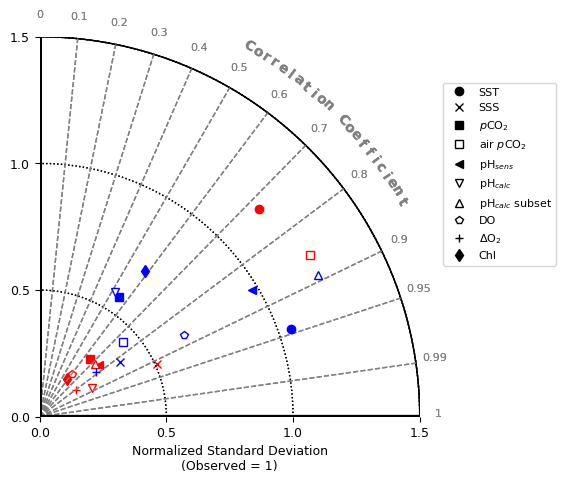

In [19]:
fig,ax=plt.subplots(1,1,figsize=(8,5))

td=sm.taylor_diagram(ax,np.array(dd2['sdev']),
                  np.array(dd2['crmsd']),
                  np.array(dd2['ccoef']),
                  titleRMS = 'off', showlabelsRMS = 'off', tickRMS =[0.0],
                    colCOR = 'gray', styleCOR = '--',
                     markerLegend = 'on',markerLabel = labels,markers=markers2)
td=sm.taylor_diagram(ax,np.array(dd['sdev']),
                  np.array(dd['crmsd']),
                  np.array(dd['ccoef']),MarkerDisplayed='marker',
                  titleRMS = 'off', showlabelsRMS = 'off', tickRMS =[0.0],
                    colCOR = 'gray', styleCOR = '--',
                     markerLegend = 'on',markerLabel = labels,markers=markers1)

ax.set_xlabel('Normalized Standard Deviation\n(Observed = 1)',fontsize=9)
ax.set_ylabel('')

plt.setp(ax.get_lines(),markeredgewidth=1)

leg = ax.get_legend()
leg.remove()
lpts=[]
lbls=[]
for el in markers2:
    fc='w' if markers2[el]['faceColor']=='w' else 'k'
    a,=ax.plot(0,0,marker=markers2[el]['symbol'],color='k',ms=ms,linestyle='None',markerfacecolor=fc)
    lpts.append(a)
    lbls.append(el)
fig.legend(lpts,lbls,loc='center', bbox_to_anchor=(0.45, 0.35, 0.5, 0.5))
for el in lpts:
    el.remove()

fig.savefig('/home/ebo/OAPMSE/paperFigs/taylor.png',dpi=400,bbox_inches='tight')

In [10]:
tar=sm.target_statistics(pred,ref,'data')

In [11]:
tar

{'bias': -0.4866413867013686,
 'crmsd': 0.5136462569888172,
 'rmsd': 0.707567888311258,
 'type': 'unnormalized'}

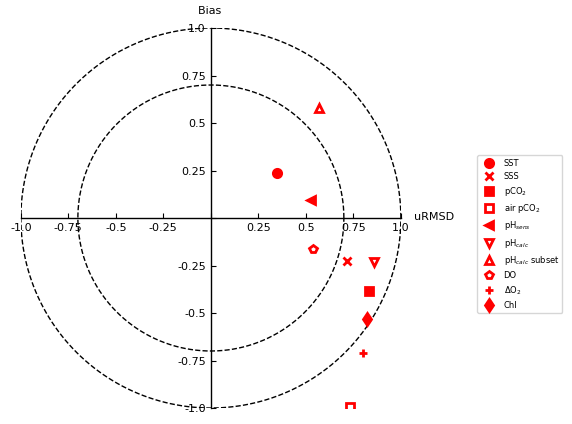

In [12]:
sm.target_diagram(np.array(tt['bias'])/np.array(tt['ostd']),np.array(tt['crmsd'])/np.array(tt['ostd']),
                  np.array(tt['rmsd'])/np.array(tt['ostd']),
                  markerLegend = 'on',markerLabel = labels,markers=markers2)

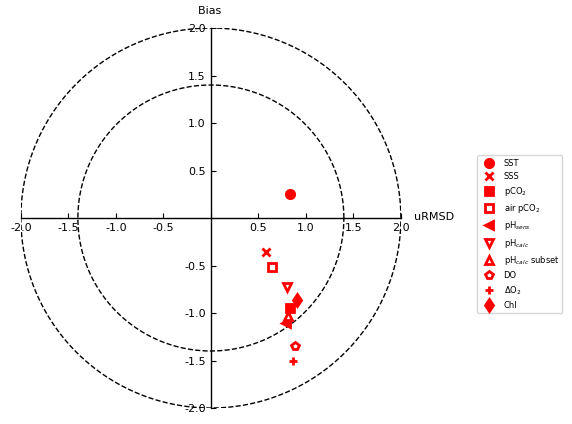

In [13]:
sm.target_diagram(np.array(tt2['bias'])/np.array(tt2['ostd']),np.array(tt2['crmsd'])/np.array(tt2['ostd']),
                  np.array(tt2['rmsd'])/np.array(tt2['ostd']),
                  markerLegend = 'on',markerLabel = labels,markers=markers2)